# **Predicting Artist Popularity using Artist Genres and Album Release Decade**

In this notebook, we will be using various regression and classification models to <u>*predict the artist popularity score of a Spotify artist*</u>. 

#### **Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.svm import SVC


## **Data Cleaning**

In [2]:
#Reading in our dataset
data = pd.read_csv("datasets/merged20k.csv") 

#Viewing our dataset's info and head
data.info() 
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18482 entries, 0 to 18481
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Track Name          18482 non-null  object 
 1   Danceability        18482 non-null  float64
 2   Energy              18482 non-null  float64
 3   Key                 18482 non-null  float64
 4   Loudness            18482 non-null  float64
 5   Mode                18482 non-null  float64
 6   Speechiness         18482 non-null  float64
 7   Acousticness        18482 non-null  float64
 8   Instrumentalness    18482 non-null  float64
 9   Liveness            18482 non-null  float64
 10  Valence             18482 non-null  float64
 11  Tempo               18482 non-null  float64
 12  Time Signature      18482 non-null  float64
 13  Track URI           18482 non-null  object 
 14  Track Popularity    18482 non-null  int64  
 15  Artist Popularity   18482 non-null  int64  
 16  Arti

,Track Name,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,...,Tempo,Time Signature,Track URI,Track Popularity,Artist Popularity,Artist URI,Album Release Date,Artist Genres,Release Year,Decade Released
0,act ii: date @ 8 (feat. Drake) - remix,0.550,0.545,0.0,-9.304,1.0,0.1630,0.3180,0.000000,0.0608,...,102.469,4.0,spotify:track:3QS9ZCtoSCJhmaJ7QNXSAS,87,74,spotify:artist:5fi7lIgJGH3RgUpJYcffQ7,2024-03-08,NaN,2024,2020s
1,LEAP!,0.892,0.585,11.0,-7.269,1.0,0.1020,0.1460,0.000004,0.0881,...,104.011,4.0,spotify:track:3vl2uH4D2QItFFhzz5L06g,38,49,spotify:artist:20WmX0l9JgOpehDOAXY6iO,2020-10-02,NaN,2020,2020s
2,Overdrive,0.568,0.788,5.0,-6.280,1.0,0.0377,0.0101,0.000000,0.1410,...,104.959,4.0,spotify:track:3QyoC6OvQUmpQwQZ18iaTs,66,81,spotify:artist:4Uc8Dsxct0oMqx0P6i60ea,2021-02-19,"bedroom pop, pop, pov: indie",2021,2020s
3,Raise y_our glass,0.567,0.503,8.0,-6.119,1.0,0.1240,0.5810,0.000000,0.3690,...,72.798,4.0,spotify:track:7j1vFohEm1lbsctYY9gyGd,60,69,spotify:artist:13yWtUnz63q5VIs5SwoMhy,2022-08-09,NaN,2022,2020s
4,In My Mind,0.668,0.392,2.0,-12.178,0.0,0.0585,0.7890,0.002750,0.3450,...,135.936,3.0,spotify:track:2W779g2UrRZtVdf3FcEOO1,73,62,spotify:artist:4pfy05cNNTacuOQ6SiSu4v,2021-08-20,gen z singer-songwriter,2021,2020s


As observed, there are some rows with empty values in the column of "Artist Genres". We will need to remove these rows as they will not be useful in our analysis.

In [3]:
#Dropping all rows where "Artist Genres" is empty
cleaned_data = data.dropna(subset=['Artist Genres']) 
cleaned_data.shape

(17473, 21)

Let us also filter out the columns that we will be using for our prediction models, and remove any duplicate artists.

In [4]:
#We will only be needing these columns in our analysis
cleaned_data = cleaned_data[["Artist Genres", "Artist URI", "Artist Popularity", "Album Release Date"]] 
cleaned_data.shape

cleaned_data.drop_duplicates(subset=["Artist URI"], inplace=True, keep='first') 

In [7]:
cleaned_data.shape

(5027, 6)

In [8]:
# Convert decade release column to integers
cleaned_data['Numerical Decade Released'] = cleaned_data['Decade Released'].map({
    '1940s': 1940,
    '1950s': 1950,
    '1960s': 1960,
    '1970s': 1970,
    '1980s': 1980,
    '1990s': 1990,
    '2000s': 2000,
    '2010s': 2010,
    '2020s': 2020,
})

There are multiple rows with multiple genres. We want to convert this string of multiple genres to an array of genres instead.

In [9]:
#Splitting the string by commas
cleaned_data["separated genres"] = data["Artist Genres"].str.split(',') 

#Stripping whitespace from the splitted strings
cleaned_data["separated genres"] = cleaned_data["separated genres"].apply(lambda genres: [genre.strip() if isinstance(genre, str) else genre for genre in genres]) 

cleaned_data["separated genres"]

2                           [bedroom pop, pop, pov: indie]
4                                [gen z singer-songwriter]
6                                                    [pop]
9                                                  [k-pop]
10       [bedroom pop, bubblegrunge, indie pop, pov: in...
                               ...                        
18452                                [pop rock, power pop]
18460                        [american folk revival, folk]
18476                  [house, breaks, experimental house]
18478                                      [german techno]
18479                 [australian dance, melbourne bounce]
Name: separated genres, Length: 5027, dtype: object

---

# **Regression Models to predict Artist Popularity**


## <u>**Linear Regression**</u>

Let us try to predict Artist Popularity using Linear Regression. Before we proceed, we will need to convert the genre list of each artist into binary labels. Since each artist can have multiple genres, we will need to use MultiLabelBinarizer to obtain a binary matrix.

In [10]:
#Applying MultiLabelBinarizer on our arrays of genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(cleaned_data['separated genres'])

Now that genres is now represented by a binary matrix, we can set our predictor and respone variables.

In [11]:
#Setting the predictor variable as a combination of genres and album release date
X = np.hstack((genres_encoded, cleaned_data['Numerical Decade Released'].values.reshape(-1,1)))

#Setting the response variable as the artist popularity
y = cleaned_data['Artist Popularity']

Now let us carry out Linear Regression.

In [12]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#Initialising the model
linreg = LinearRegression()

#Fitting the model on the train data
linreg.fit(X_train, y_train)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

#Predicting the train and test response variable
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

Intercept of Regression 	: b =  39.72080442491707
Coefficients of Regression 	: a =  [-1.00247567e+01 -1.04772220e+11  8.76062063e+10 ... -5.83047770e+00
  0.00000000e+00  3.82995605e-03]



Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6717300136435115
Mean Squared Error (MSE): 	: 87.54886919611556
Root Mean Squared Error (RMSE): 	: 9.356755270718347
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -4.8216410413310886e+17
Mean Squared Error (MSE) : 	: 1.34441790056108e+20
Root Mean Squared Error (RMSE): 	: 11594903624.269932



Text(0.5, 1.0, 'Test Dataset')

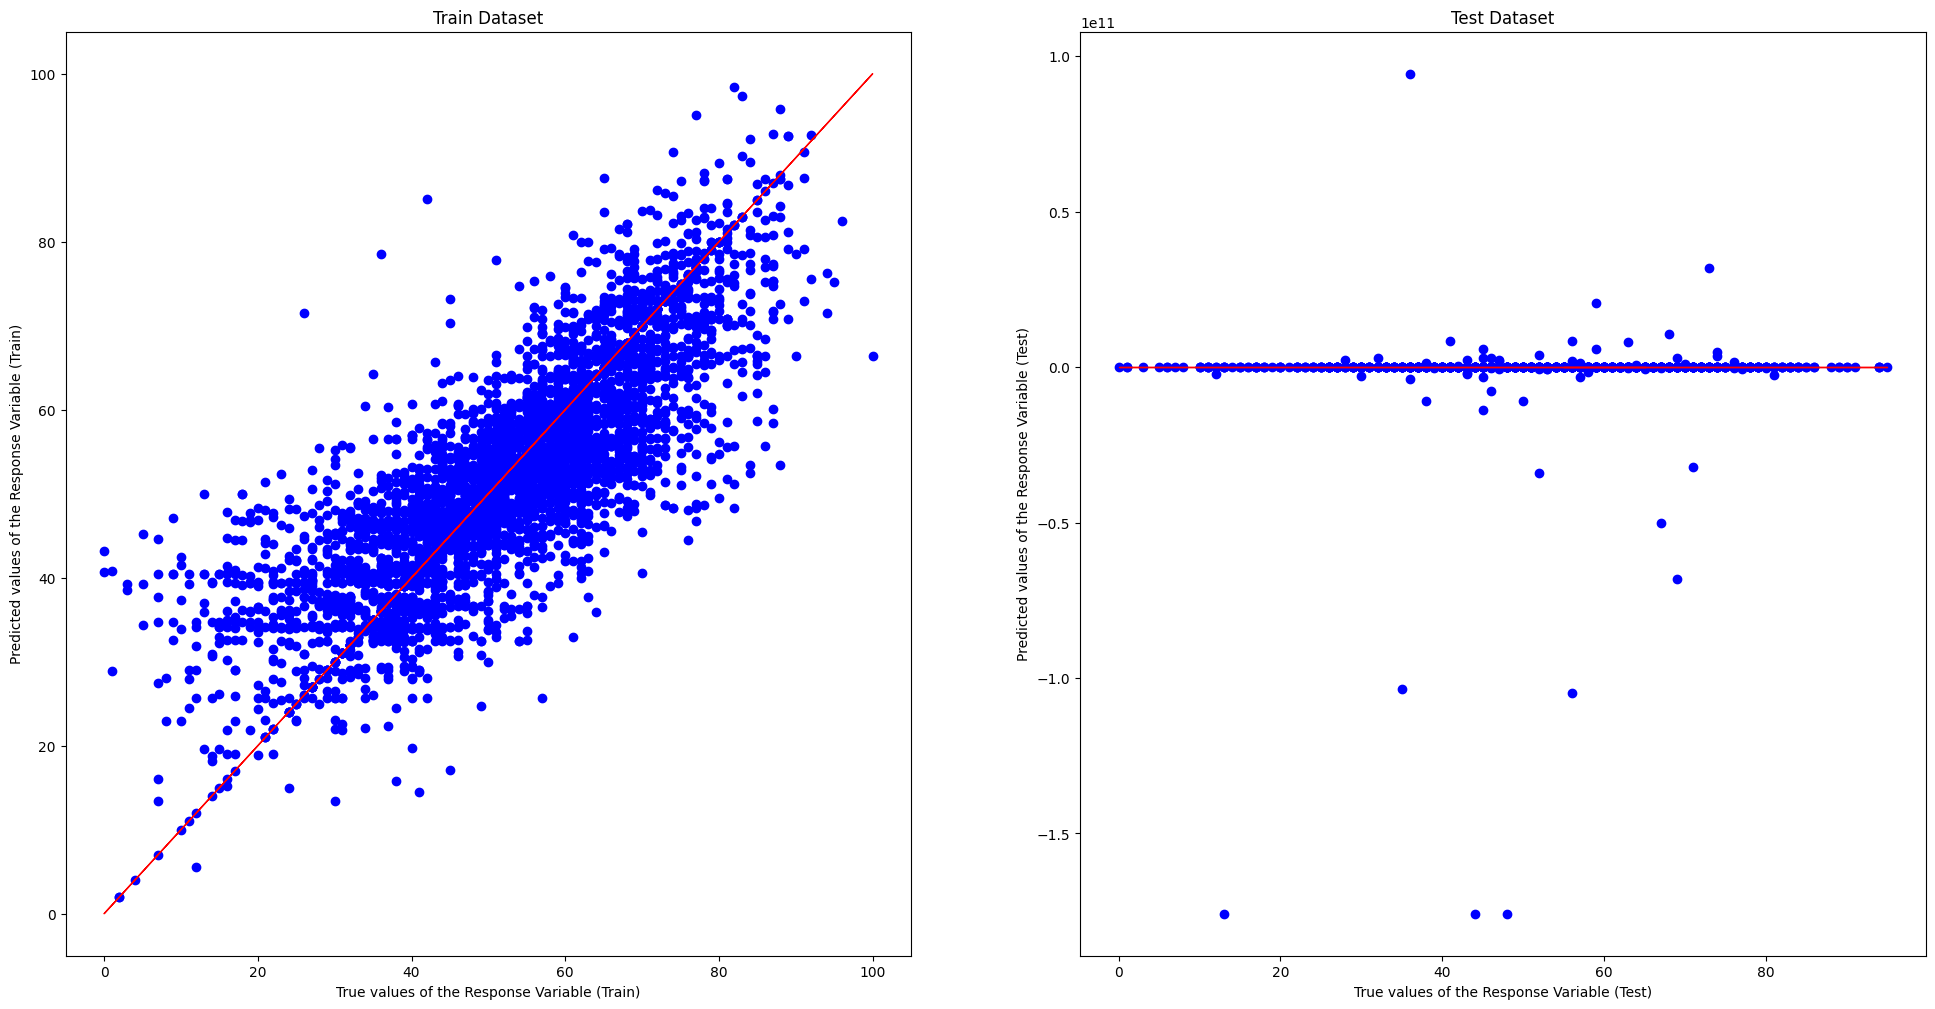

In [13]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))


# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

As expected, linear regression has proven to fail miserably. Looking at our test data, our model clearly fails as it predicts artist popularity to values as far off as 10^10, when our range for artist popularity is only 0 to 100. Perhaps we should look at other models that are more suited to analyse the complex relationships here.

## <u>**Lasso Regression**</u>

Let us try with Lasso Regression. LASSO stands for Least Absolute Shrinkage and Selection Operator. Essentially, it does feature selection and regularisation in order to enhance prediction accuracy.

In [14]:
# Using LassoCV to select features based on the strength of the regularization
selector = SelectFromModel(LassoCV(cv=5, random_state=20))
X_selected = selector.fit_transform(X, y)

#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=20)

#Printing the shape of X
print("X shape: " + str(X.shape))

#Printing the shape of X_selected
print("X_selected shape: " + str(X_selected.shape))

X shape: (5027, 1525)
X_selected shape: (5027, 98)


As seen, Lasso has reduced the number of columns rather drastically. It has done so by removing features (columns) that it has deemed to be insignificant or irrelevant.

In [15]:
#Initialising the model
lassoreg = LinearRegression()

#Fitting the model on the train data
lassoreg.fit(X_train, y_train)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', lassoreg.intercept_)
print('Coefficients of Regression \t: a = ', lassoreg.coef_)
print()

#Predicting the train and test response variable
y_train_pred = lassoreg.predict(X_train)
y_test_pred = lassoreg.predict(X_test)

Intercept of Regression 	: b =  -126.65431525884692
Coefficients of Regression 	: a =  [  2.13777675   3.46723019   9.9644608    9.06542089   5.52881866
  -6.63249664  -4.77060861  -4.47371783  -8.39726261  -8.17702573
 -15.31162083   7.6745207   -2.11686532  -8.54663735 -12.82282237
  -6.12376449   1.63256716 -28.37905133  -5.65129752  -3.26943407
 -10.59134145 -16.92961437   4.93698663 -10.89547866   6.82903091
   5.04552798  11.41583238  -5.36418608   2.68260064 -19.64517023
   9.10167937  -7.15404896   6.12712436   4.66123002   3.98766092
   8.65985752  23.67194923 -11.55262009  -3.97680392   1.31973595
   1.04825198   1.70177976  12.08756625   4.79648946  -5.63501384
  11.55561817   7.30510973   4.01338446  14.28880516  -1.7641417
  11.84694233 -12.10819586   7.07395988  13.79228013   6.5474301
  -0.23826554   7.22878047   6.92273185  10.03511517  14.66164669
   6.38086537   2.92753561   1.26833743   1.48546686   0.82073157
 -20.34681203  13.77098731   6.63062156  18.08068712   7.

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.4697600317765488
Mean Squared Error (MSE): 	: 141.4138104302201
Root Mean Squared Error (RMSE): 	: 11.891753883688482
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.4119132635086268
Mean Squared Error (MSE) : 	: 163.97619168333654
Root Mean Squared Error (RMSE): 	: 12.805318882532232



Text(0.5, 1.0, 'Test Dataset')

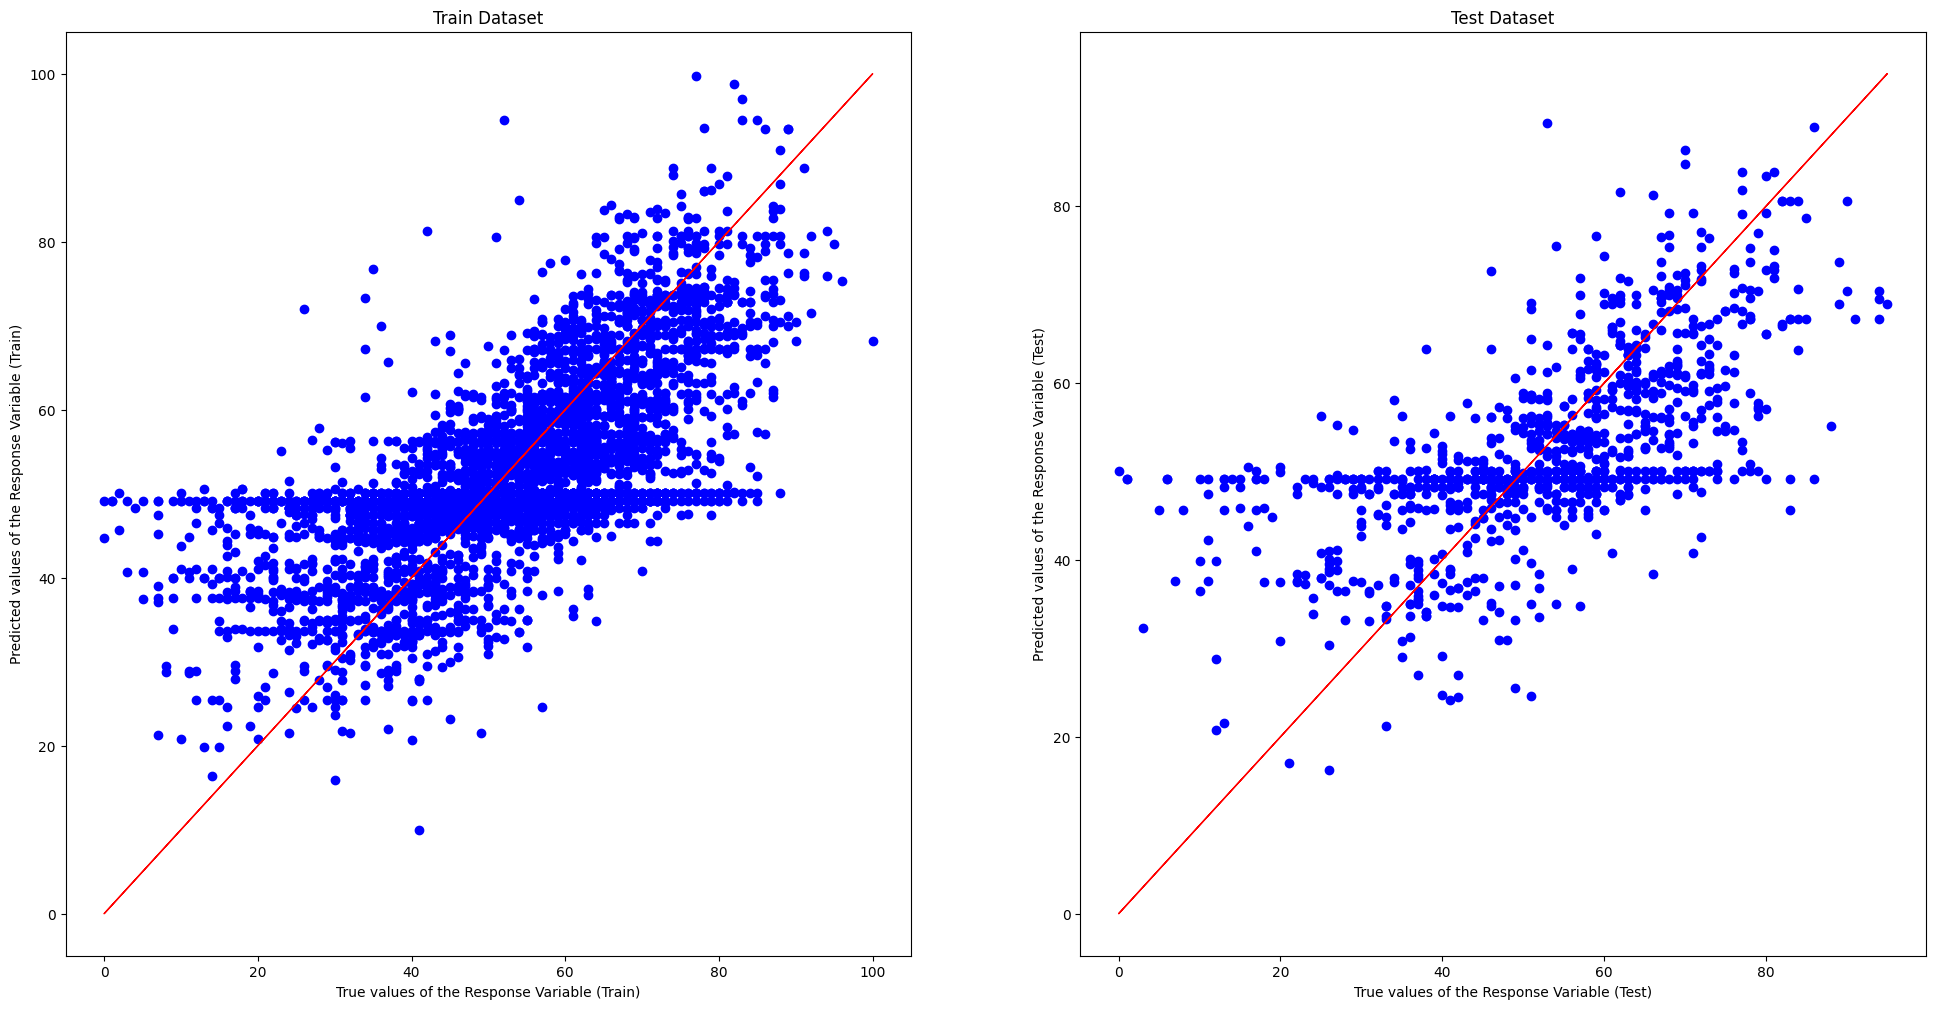

In [16]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", lassoreg.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", lassoreg.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

## <u>**Random Forest Regression**</u>

Random Forest works by constructing mutliple decision trees, but when splitting a node, it randomly selects a subset of the features as candidates for the split, and this randomness help to make the model more robust to noise in the data, as well as capture the complex interactions between predictor variables.

In [17]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#Initialising the Random Forest Regressor model
RFR = RandomForestRegressor(n_estimators=100, random_state=20)

#Fitting the model on the train data
RFR.fit(X_train, y_train)

#Predicting the train and test response variable
y_train_pred = RFR.predict(X_train)
y_test_pred = RFR.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8604345148361288
Mean Squared Error (MSE): 	: 37.221801909221824
Root Mean Squared Error (RMSE): 	: 6.100967292915265
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5129742591072709
Mean Squared Error (MSE) : 	: 135.79735996055174
Root Mean Squared Error (RMSE): 	: 11.653212430937305



Text(0.5, 1.0, 'Test Dataset')

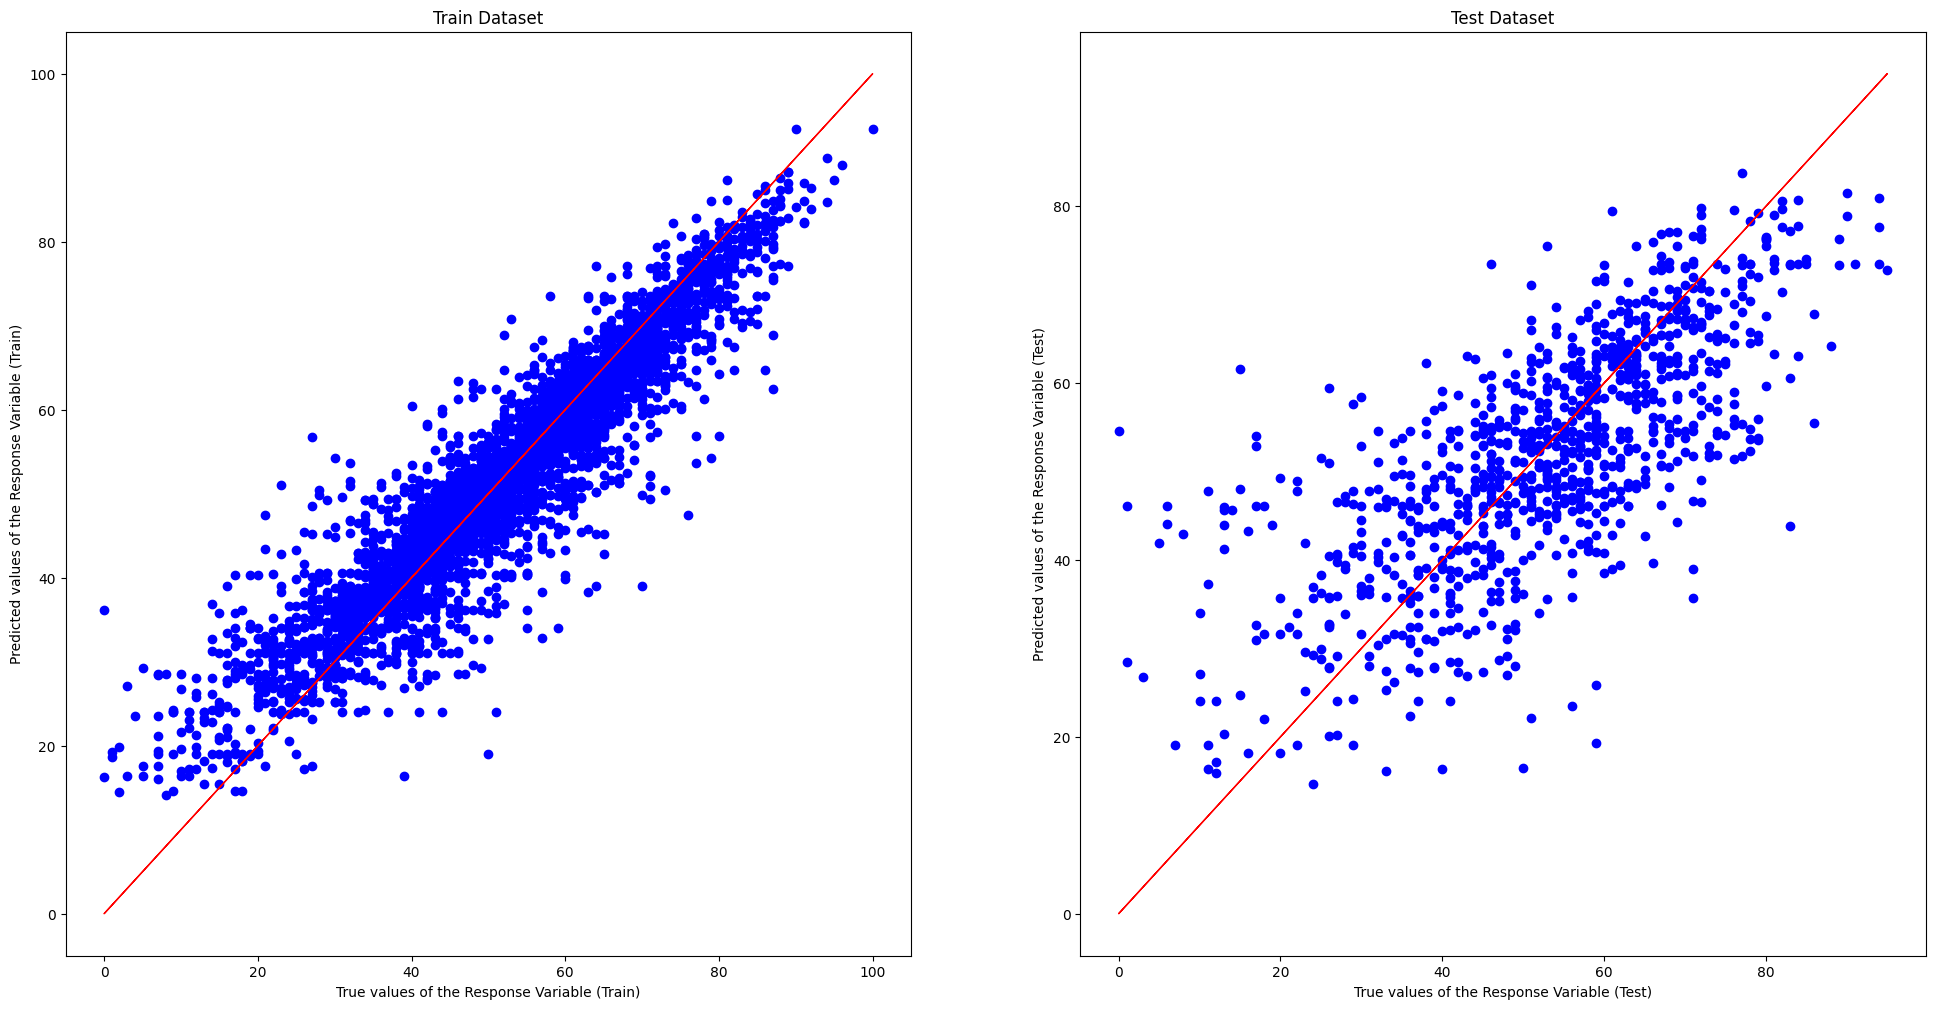

In [18]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", RFR.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", RFR.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

## <u>**Neural Network**</u>

Neural Network is a Machine Learning technique inspired by neural networks in animals, designed to recognise patterns. These neural networks receive input in the input layer and passes it into the hidden layer, where it performs computations using weighted inputs from many successive previous layers and passes it down again, before finally being output in the output layer.

In [19]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Determine the number of input features
input_dim = X_train.shape[1]

NN = Sequential()
NN.add(Dense(128, input_dim=input_dim, activation='relu'))
NN.add(Dense(64, activation='relu'))
NN.add(Dense(1, activation='linear'))  # Linear activation for a single-value regression output
NN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

history = NN.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

#Predicting the train and test response variable
y_train_pred = NN.predict(X_train)
y_test_pred = NN.predict(X_test)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1543.6627 - mae: 26.7785 - mse: 1543.6627 - val_loss: 305.5303 - val_mae: 13.7736 - val_mse: 305.5303
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 259.1717 - mae: 12.8481 - mse: 259.1717 - val_loss: 285.7563 - val_mae: 13.5379 - val_mse: 285.7563
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 252.9071 - mae: 12.6917 - mse: 252.9071 - val_loss: 282.0255 - val_mae: 13.5223 - val_mse: 282.0255
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 255.9572 - mae: 12.7847 - mse: 255.9572 - val_loss: 276.0887 - val_mae: 13.1769 - val_mse: 276.0887
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 243.6399 - mae: 12.4266 - mse: 243.6399 - val_loss: 269.4678 - val_mae: 13.1667 - val_mse: 269.4678
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 237.0627 - mae: 12.2509 - mse: 237.0627 - val_loss: 262.2226 - val_mae: 12.8053 - val_mse: 262.2226
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6082340493616818
Mean Squared Error (MSE): 	: 104.48310047656616
Root Mean Squared Error (RMSE): 	: 10.22169753399924
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.40765887210672325
Mean Squared Error (MSE) : 	: 165.1624433988175
Root Mean Squared Error (RMSE): 	: 12.851554123872237



Text(0.5, 1.0, 'Test Dataset')

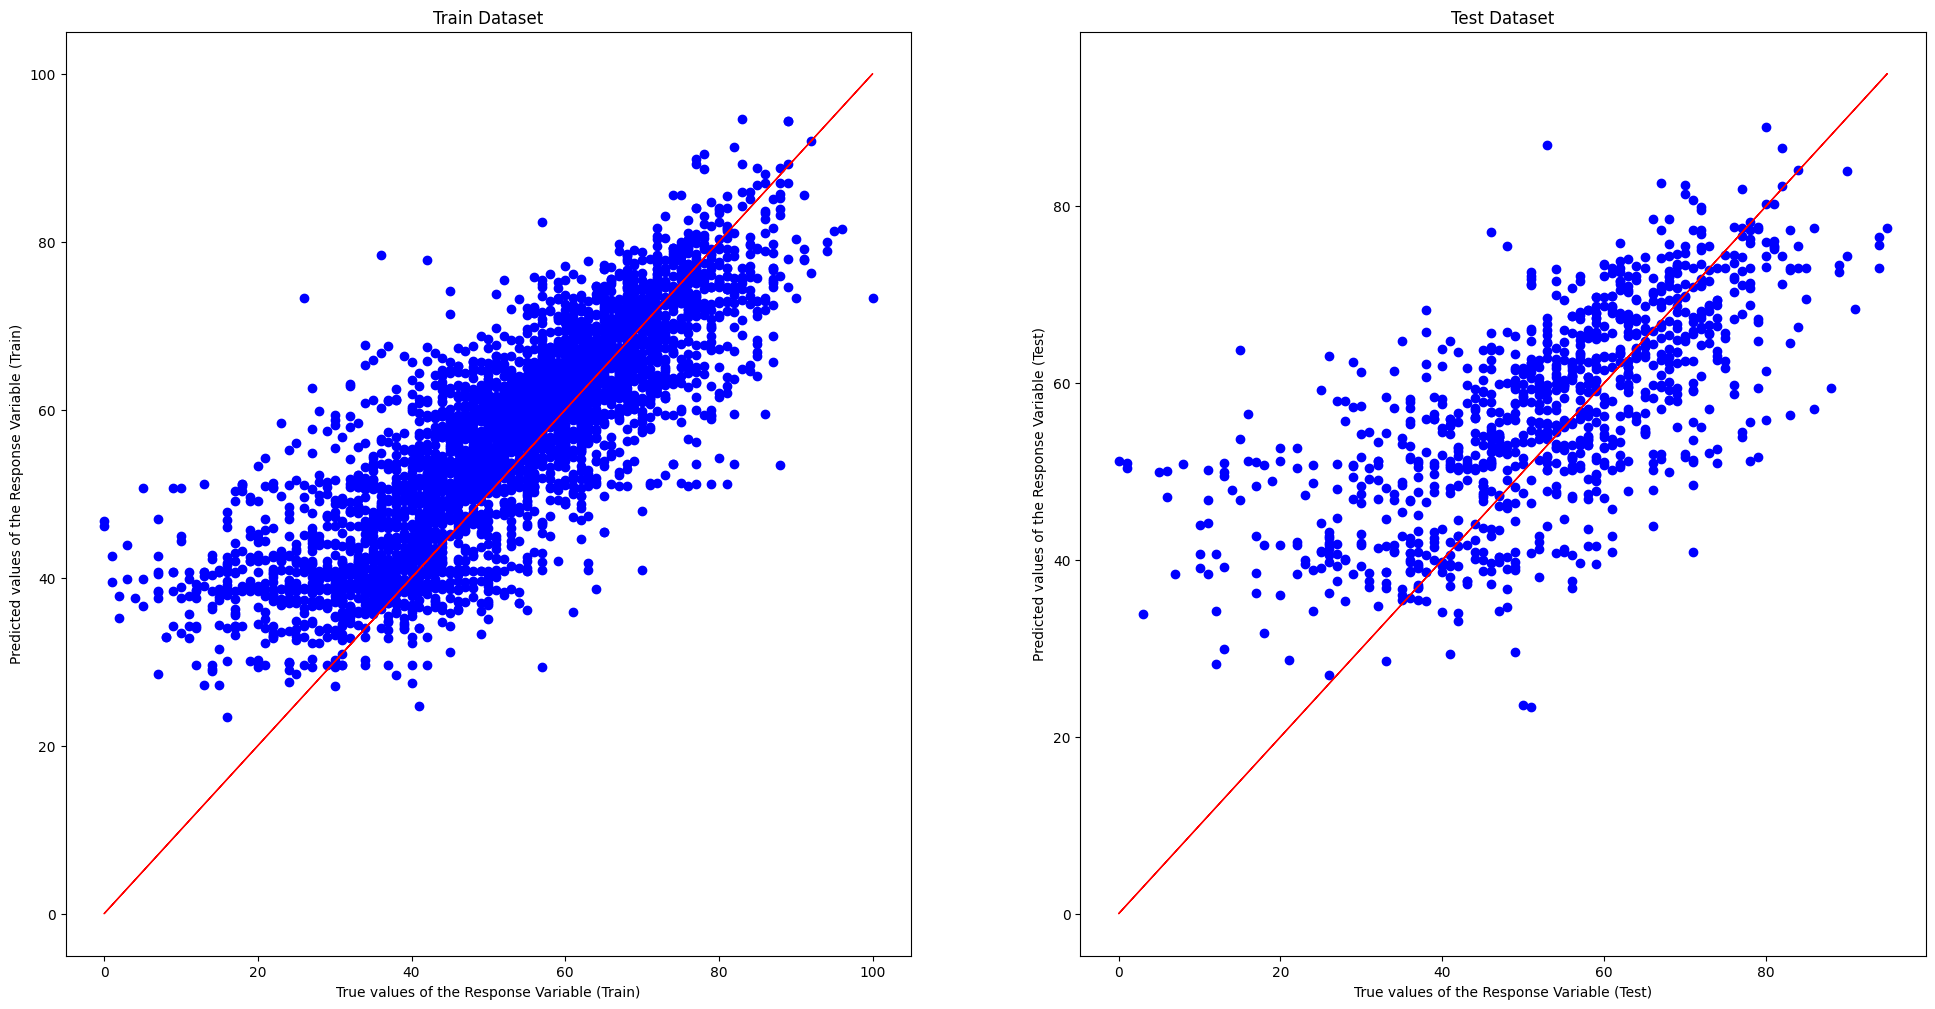

In [20]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test, y_test_pred))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

## <u>**Gradient Boosting with Decision Trees**</u>

Gradient boosting with decision trees is essentially a series of decision trees which aim to correct the mistakes of the previous decision tree model.

In [21]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

GBR = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=20)

# Fitting the model on the train data
GBR.fit(X_train, y_train)

#Predicting the train and test response variable
y_train_pred = GBR.predict(X_train)
y_test_pred = GBR.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6627754125426639
Mean Squared Error (MSE): 	: 89.93704122848085
Root Mean Squared Error (RMSE): 	: 9.483514181382388
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.45969292712382936
Mean Squared Error (MSE) : 	: 150.65379076289557
Root Mean Squared Error (RMSE): 	: 12.2741105894845



Text(0.5, 1.0, 'Test Dataset')

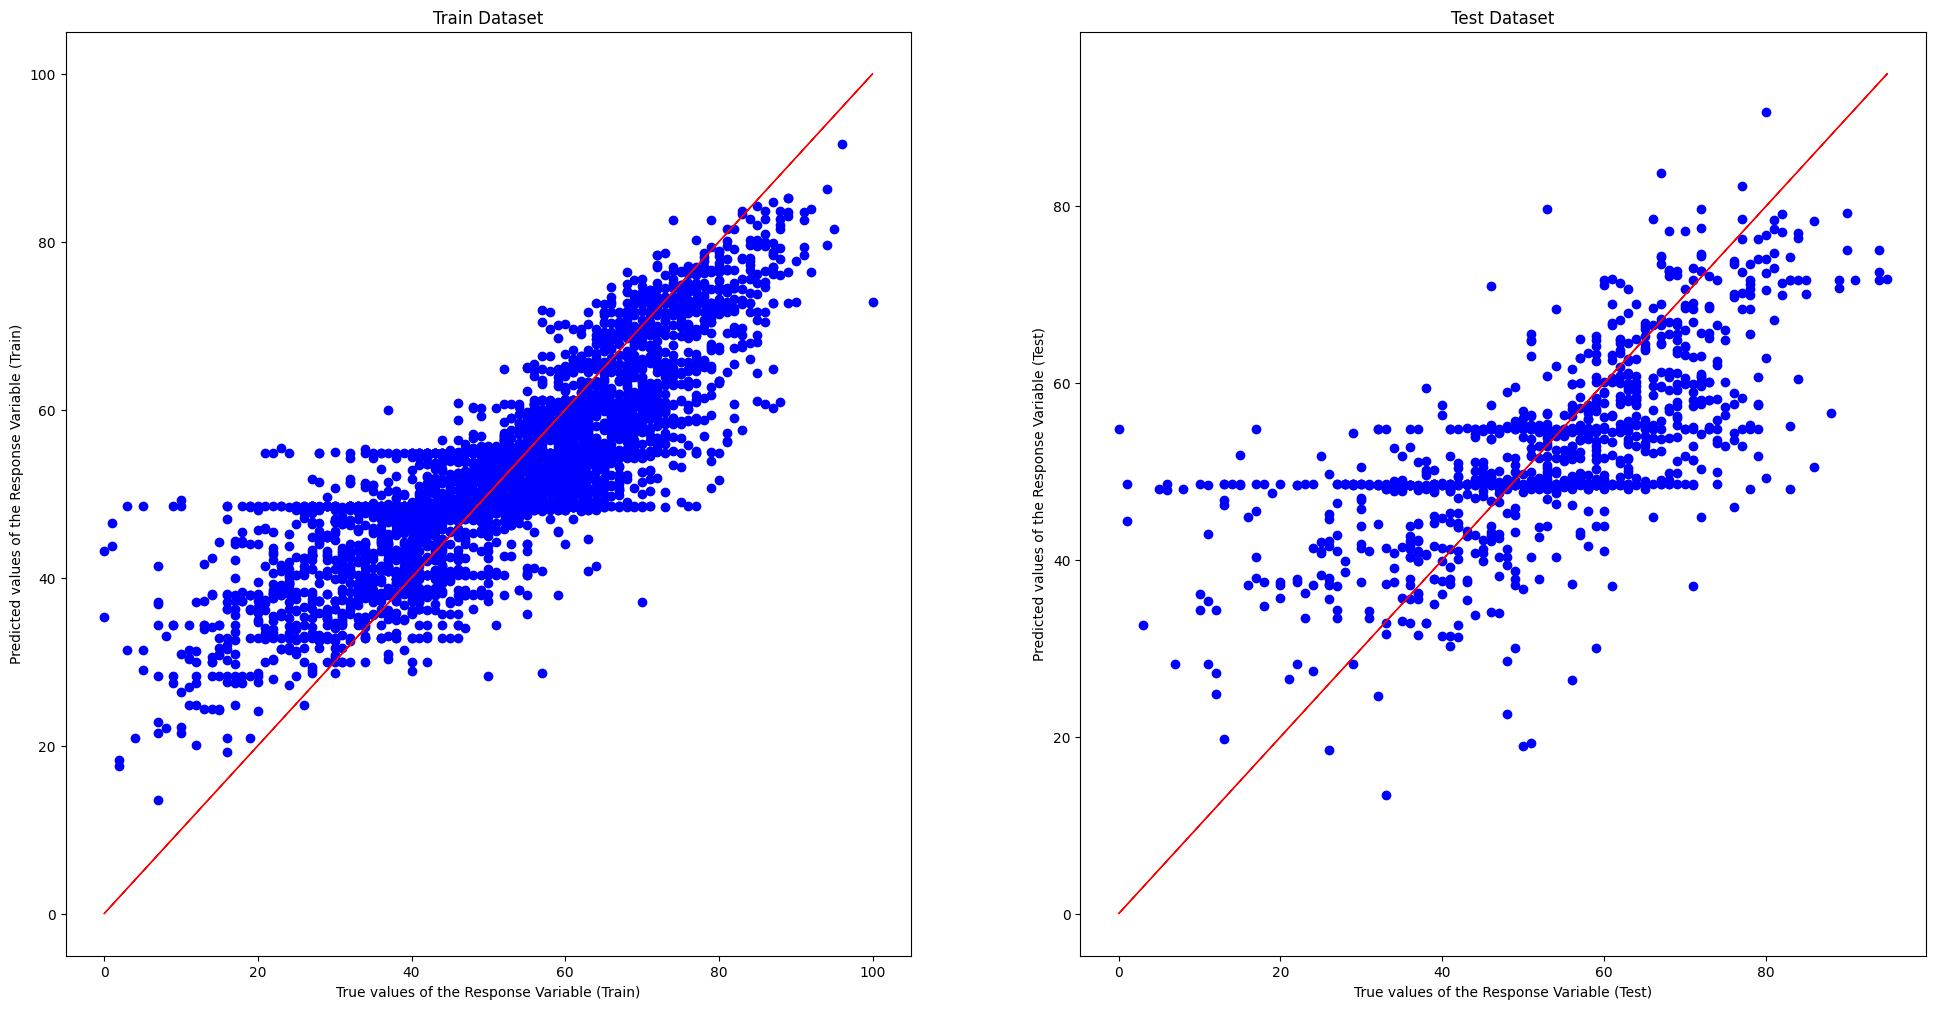

In [22]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", GBR.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", GBR.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

### <u>**Evaluation**</u>

Comparing the regression models, <u>***Random Forest Regression***</u> is likely the best model, since it has the <u>greatest explained variance</u>, and also has the <u>lowest RMSE</u>

However, it still has its limitations, as the explained variance is not exactly very high, nor is the RMSE low either. Hence, the model could be useful in predicting an approximation of the Artist Popularity, but the results should be taken with a pinch of salt.

Despite its somewhat low level of accuracy, when considering these results in the field of social science, the accuracy can actually be considered to be rather decent.

---

# **Classification Models to predict Artist Popularity**
After evaluating the above regression models, it was not the most accurate predictor of artist popularity, or at least could not reliably predict the exact artist popularity level. Perhaps our models will be more reliable if we convert it into a classification problem and determine simply if the artist will be popular or not.

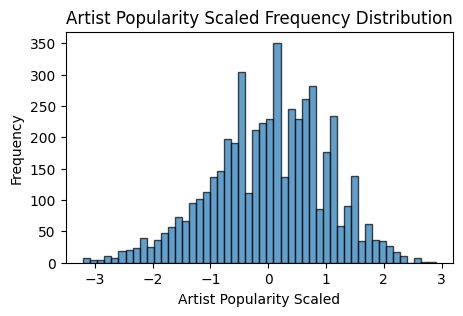

In [23]:
# Normalising and scaling artist popularity
artist_scaler = StandardScaler()
cleaned_data['Artist Popularity Scaled'] = artist_scaler.fit_transform(cleaned_data[['Artist Popularity']])

# Plot a histogram of artist popularity scaled
plt.figure(figsize=(5, 3))
plt.hist(cleaned_data['Artist Popularity Scaled'], bins=50, alpha=0.7, edgecolor='black')

plt.title('Artist Popularity Scaled Frequency Distribution')
plt.xlabel('Artist Popularity Scaled')
plt.ylabel('Frequency')
plt.show()

In order to determine if an artist is popular or not, we must first decide on a threshold for popularity. There are multiple ways of defining this threshold, but for this case, let us plot artist popularity as a normally distributed graph, with mean = 0 and standard deviation = 1. Any artists with a scaled artist popularity of greater than 0 will be deemed popular, while all other artists will be deemed as not popular. In other words, an artist is popular if his/her popularity is greater than the median artist popularity.

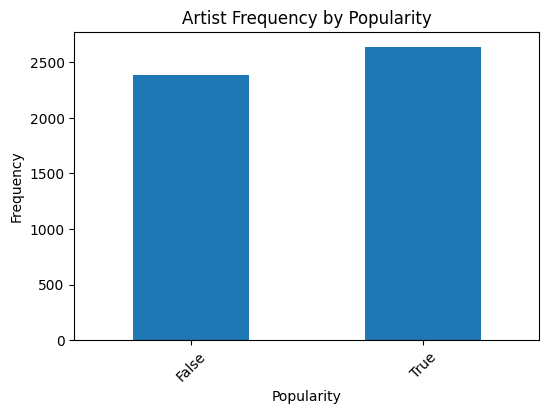

In [24]:
#function to return whether an artist is popular or not based on the scaled artist popularity
def popular_or_not(scaled_popularity):
    if scaled_popularity > 0:
        return True
    else:
        return False
    
#Creating a new column with boolean values indicating whether the artist is popular or not
cleaned_data['Popular'] = cleaned_data["Artist Popularity Scaled"].apply(popular_or_not)

popular_unpopular = cleaned_data['Popular'].value_counts().sort_index()

# Plotting the histogram/bar plot of decade frequencies
plt.figure(figsize=(6, 4))
popular_unpopular.plot(kind='bar')
plt.title('Artist Frequency by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [25]:
#Setting the predictor variable as a combination of genres and album release date
X = np.hstack((genres_encoded, cleaned_data['Numerical Decade Released'].values.reshape(-1,1)))

#Setting the response variable as the artist popularity
y = cleaned_data['Popular']

## <u>**Logistic Regression**</u>

Logistic Regression is a model that predicts binary varables based on linear combination of one or more independent variables.

True positive rate	:  0.7310469314079422
True negative rate	:  0.8030973451327433
False positive rate	:  0.19690265486725664
False negative rate	:  0.26895306859205775
Overall Accuracy	:  0.7634194831013916


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

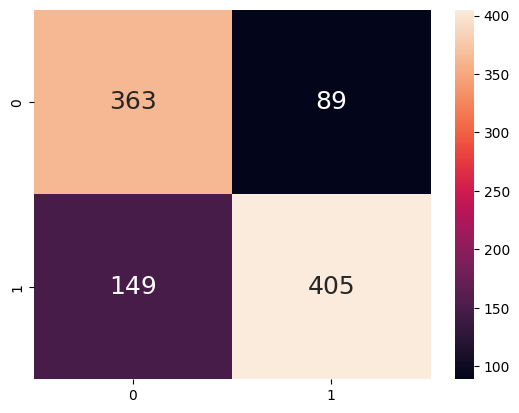

In [26]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#Initialising the model, with max iterations set at 1000 to prevent the algorithm from stopping the optimisation process before finding the best coefficients
LogReg = LogisticRegression(max_iter=1000)

#Fitting the model with the train data
LogReg.fit(X_train, y_train)

#Predicting the popularity of test data
y_pred = LogReg.predict(X_test)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

## <u>**Logistic Lasso Regression**</u>

Logistic Lasso Regression combines Logistic Regression and Lasso Regression, using feature selection and regularisation in the Logistic Regression model.

In [27]:
# Using LassoCV to select features based on the strength of the regularization
selector = SelectFromModel(LassoCV(cv=5, random_state=20))
X_selected = selector.fit_transform(X, y)

#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=20)

#Printing the shape of X
print("X shape: " + str(X.shape))

#Printing the shape of X_selected
print("X_selected shape: " + str(X_selected.shape))

X shape: (5027, 1525)
X_selected shape: (5027, 150)


True positive rate	:  0.703971119133574
True negative rate	:  0.838495575221239
False positive rate	:  0.16150442477876106
False negative rate	:  0.296028880866426
Overall Accuracy	:  0.76441351888668


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

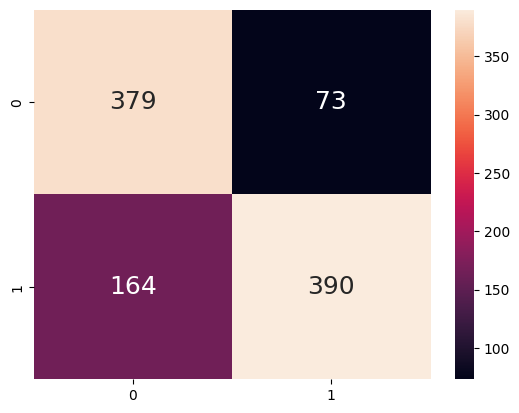

In [28]:
LogReg = LogisticRegression(max_iter=1000)
LogReg.fit(X_train, y_train)

#Predicting the popularity of test data
y_pred = LogReg.predict(X_test)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

## <u>**Random Forest Classifier**</u>

Random Forest Classifier is similar to the Random Forest Regression, but instead it outputs a class.

True positive rate	:  0.7454873646209387
True negative rate	:  0.7721238938053098
False positive rate	:  0.22787610619469026
False negative rate	:  0.2545126353790614
Overall Accuracy	:  0.757455268389662


<Axes: >

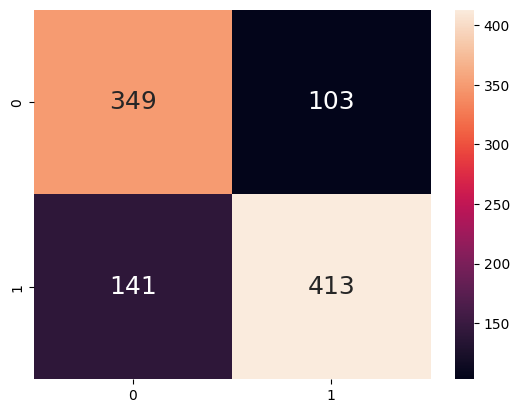

In [29]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#Initialising the Random Forest Classifier model
RFC = RandomForestClassifier(n_estimators=100, random_state=20)

#Fitting the model on the train data
RFC.fit(X_train, y_train)

#Predicting the popularity of test data
y_pred = RFC.predict(X_test)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

## <u>**Support Vector Machines**</u>

Support Vector Machines (SVMs) is based on the idea of finding a hyperplane that best divides a dataset into classes.

True positive rate	:  0.7671480144404332
True negative rate	:  0.7367256637168141
False positive rate	:  0.26327433628318586
False negative rate	:  0.2328519855595668
Overall Accuracy	:  0.7534791252485089


<Axes: >

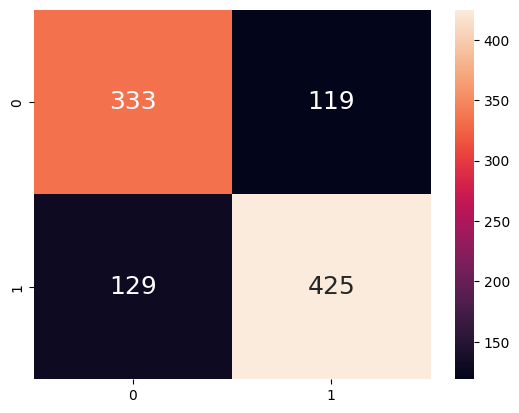

In [30]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#SVMs need the predictor variables to be scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Setting the kernal as 'rbf' is suitable for non-linear problems
SVM = SVC(kernel='rbf', random_state=20)
SVM.fit(X_train_scaled, y_train)

#Predicting the popularity of test data
y_pred = SVM.predict(X_test_scaled)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

### <u>**Evaluation**</u>
Based on the results, <u>***Logistic Lasso Regression***</u> seems to be the most Classification model. It has the <u>highest accurazy</u>, and also the <u>lowest False Positive rate</u>, which is important in minimising in our case since we do not want to waste resources investing on an artist who underperforms.

---

# **Predicting Artist Popularity**

Now that we have decided the best Regression and Classification models, we can use them to predict the popularity of artists based on the independent variables that we can set values to.

In [31]:
#Set the values of the independent variables here
new_data_genres = ["r&b"] 
new_data_decade_released = [1980]


#Reshaping the new decade into a numpy array of dimension 2
new_data_decade_released = np.array(new_data_decade_released).reshape(1, -1)

#Encoding the new genres using the same MultiLabelBinarizer as before
new_genres_encoded = mlb.transform([new_data_genres])

#Stack the features in the same order as the training data
new_X = np.hstack((new_genres_encoded, new_data_decade_released))

In [32]:
# Predict using the regression model
predicted_y = RFR.predict(new_X)

#Predict using the classification model
new_X_selected = selector.transform(new_X)
predicted_y_boolean = LogReg.predict(new_X_selected)

# Output the prediction 
print(f"The predicted artist popularity by Random Forest Regression is: {predicted_y[0]}")

if (predicted_y_boolean[0]):
    print("Logisitc Lasso Regression predicts this artist to be popular")
else:
    print("Logistic Lasso Regression predicts this artist to be NOT popular")



The predicted artist popularity by Random Forest Regression is: 64.95583333333335
Logisitc Lasso Regression predicts this artist to be popular
